In [ ]:
import pandas as pd
import numpy as np
import requests
import os
from dotenv import load_dotenv
import openmeteo_requests
import requests_cache
from retry_requests import retry
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
load_dotenv()

True

In [3]:
API_KEY = os.getenv("API_KEY")

In [ ]:
# Реальные средние температуры (примерные данные) для городов по сезонам
seasonal_temperatures = {
    "New York": {"winter": 0, "spring": 10, "summer": 25, "autumn": 15},
    "London": {"winter": 5, "spring": 11, "summer": 18, "autumn": 12},
    "Paris": {"winter": 4, "spring": 12, "summer": 20, "autumn": 13},
    "Tokyo": {"winter": 6, "spring": 15, "summer": 27, "autumn": 18},
    "Moscow": {"winter": -10, "spring": 5, "summer": 18, "autumn": 8},
    "Sydney": {"winter": 12, "spring": 18, "summer": 25, "autumn": 20},
    "Berlin": {"winter": 0, "spring": 10, "summer": 20, "autumn": 11},
    "Beijing": {"winter": -2, "spring": 13, "summer": 27, "autumn": 16},
    "Rio de Janeiro": {"winter": 20, "spring": 25, "summer": 30, "autumn": 25},
    "Dubai": {"winter": 20, "spring": 30, "summer": 40, "autumn": 30},
    "Los Angeles": {"winter": 15, "spring": 18, "summer": 25, "autumn": 20},
    "Singapore": {"winter": 27, "spring": 28, "summer": 28, "autumn": 27},
    "Mumbai": {"winter": 25, "spring": 30, "summer": 35, "autumn": 30},
    "Cairo": {"winter": 15, "spring": 25, "summer": 35, "autumn": 25},
    "Mexico City": {"winter": 12, "spring": 18, "summer": 20, "autumn": 15},
}

# Сопоставление месяцев с сезонами
month_to_season = {12: "winter", 1: "winter", 2: "winter",
                   3: "spring", 4: "spring", 5: "spring",
                   6: "summer", 7: "summer", 8: "summer",
                   9: "autumn", 10: "autumn", 11: "autumn"}

# Генерация данных о температуре
def generate_realistic_temperature_data(cities, num_years=20):
    dates = pd.date_range(start="2010-01-01", periods=365 * num_years, freq="D")
    data = []

    for city in cities:
        for date in dates:
            season = month_to_season[date.month]
            mean_temp = seasonal_temperatures[city][season]
            # Добавляем случайное отклонение
            temperature = np.random.normal(loc=mean_temp, scale=5)
            data.append({"city": city, "timestamp": date, "temperature": temperature})

    df = pd.DataFrame(data)
    df['season'] = df['timestamp'].dt.month.map(lambda x: month_to_season[x])
    return df

# Генерация данных
data = generate_realistic_temperature_data(list(seasonal_temperatures.keys()))
data.to_csv('temperature_data.csv', index=False)

In [4]:
def analysis_time_series(df, city, date_col='timestamp', temp_col='temperature', window=30, plot=True):
    # Копируем данные, чтобы не изменять оригинал
    df = df[df["city"]==city].copy()
    
    # Убедимся, что колонка даты — datetime
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col).reset_index(drop=True)
    
    # Скользящее среднее и стандартное отклонение
    df['rolling_mean'] = df[temp_col].rolling(window=window, center=True).mean()
    df['rolling_std'] = df[temp_col].rolling(window=window, center=True).std()
    
    # Границы аномалий: ±2σ
    df['upper_bound'] = df['rolling_mean'] + 2 * df['rolling_std']
    df['lower_bound'] = df['rolling_mean'] - 2 * df['rolling_std']
    
    # Маска аномалий
    df['is_anomaly'] = (df[temp_col] > df['upper_bound']) | (df[temp_col] < df['lower_bound'])
    anomalies = df[df['is_anomaly']].copy()
    
    # Долгосрочный тренд: линейная регрессия по времени
    # Преобразуем дату в числовой формат (дни с начала)
    df['days_since_start'] = (df[date_col] - df[date_col].min()).dt.days
    X = df['days_since_start'].values
    y = df[temp_col].values
    
    # Убираем NaN из-за rolling window
    valid = ~np.isnan(df['rolling_mean'])
    X_valid, y_valid = X[valid], y[valid]
    
    # Линейная регрессия (вручную, без внешних зависимостей)
    A = np.vstack([X_valid, np.ones(len(X_valid))]).T
    slope, intercept = np.linalg.lstsq(A, y_valid, rcond=None)[0]
    
    df['trend'] = slope * df['days_since_start'] + intercept
    
    if plot:
        plt.figure(figsize=(14, 8))
        sns.set(style="whitegrid")
        
        # Основной график
        plt.plot(df[date_col], df[temp_col], label='Температура', color='lightgray', linewidth=0.8)
        plt.plot(df[date_col], df['rolling_mean'], label=f'Скользящее среднее ({window} дней)', color='steelblue', linewidth=2)
        plt.plot(df[date_col], df['trend'], label='Долгосрочный тренд', color='red', linestyle='--', linewidth=2)
        
        # Границы аномалий
        plt.fill_between(df[date_col], df['lower_bound'], df['upper_bound'], color='orange', alpha=0.2, label='±2σ')
        
        # Аномалии
        if not anomalies.empty:
            plt.scatter(anomalies[date_col], anomalies[temp_col], color='red', label='Аномалии', zorder=5, s=30)
        
        plt.title(f'Анализ временного ряда температуры ({city})')
        plt.xlabel('Дата')
        plt.ylabel('Температура (°C)')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        # График только аномалий (если есть)
        if not anomalies.empty and len(anomalies) <= 100:  # избегаем перегрузки
            plt.figure(figsize=(12, 4))
            plt.plot(df[date_col], df['rolling_mean'], label='Скользящее среднее', color='steelblue')
            plt.scatter(anomalies[date_col], anomalies[temp_col], color='red', label='Аномалии')
            plt.title('Аномальные значения температуры')
            plt.xlabel('Дата')
            plt.ylabel('Температура (°C)')
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    return {
        'df_enriched': df,
        'anomalies': anomalies,
        'trend_slope': slope,             # °C в день
        'trend_intercept': intercept
    }

In [5]:
data = pd.read_csv('temperature_data.csv')

In [6]:
cities = data.city.unique().tolist()

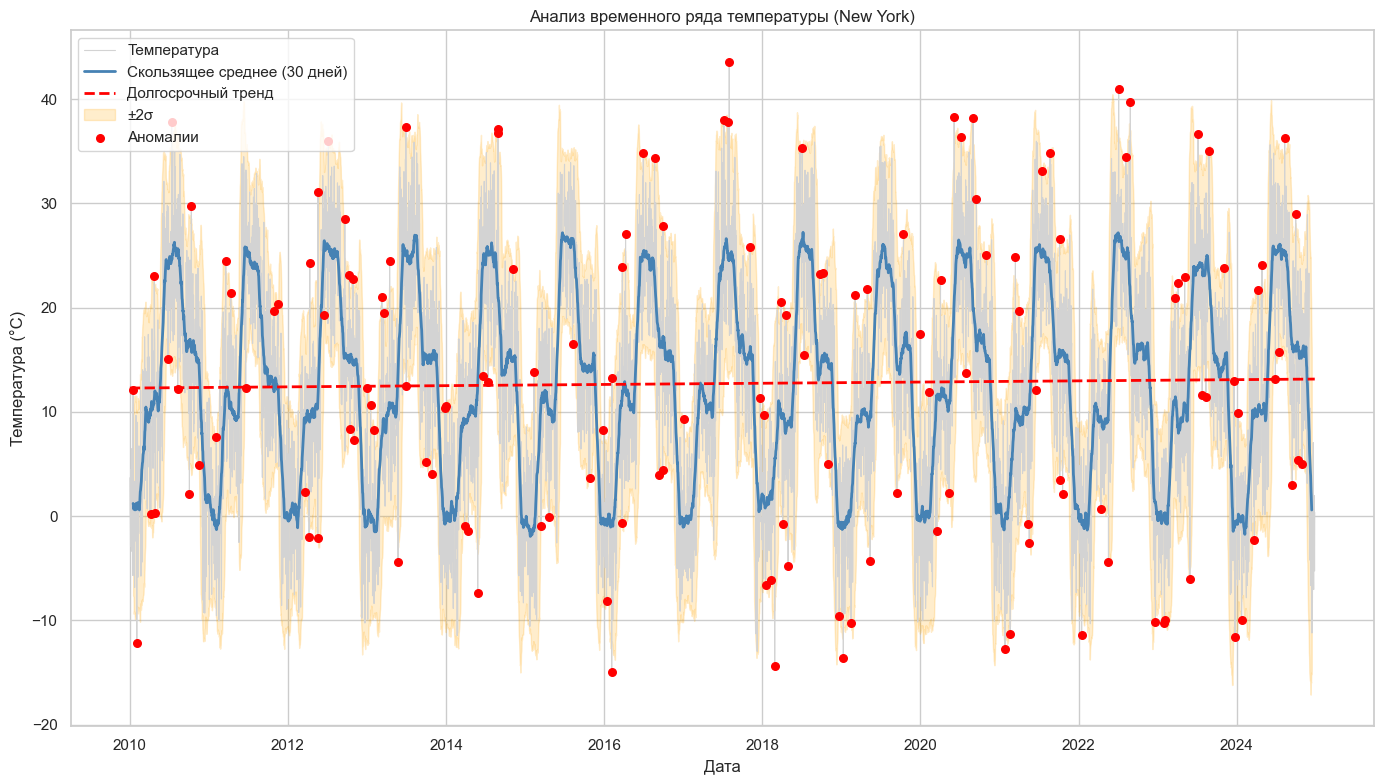

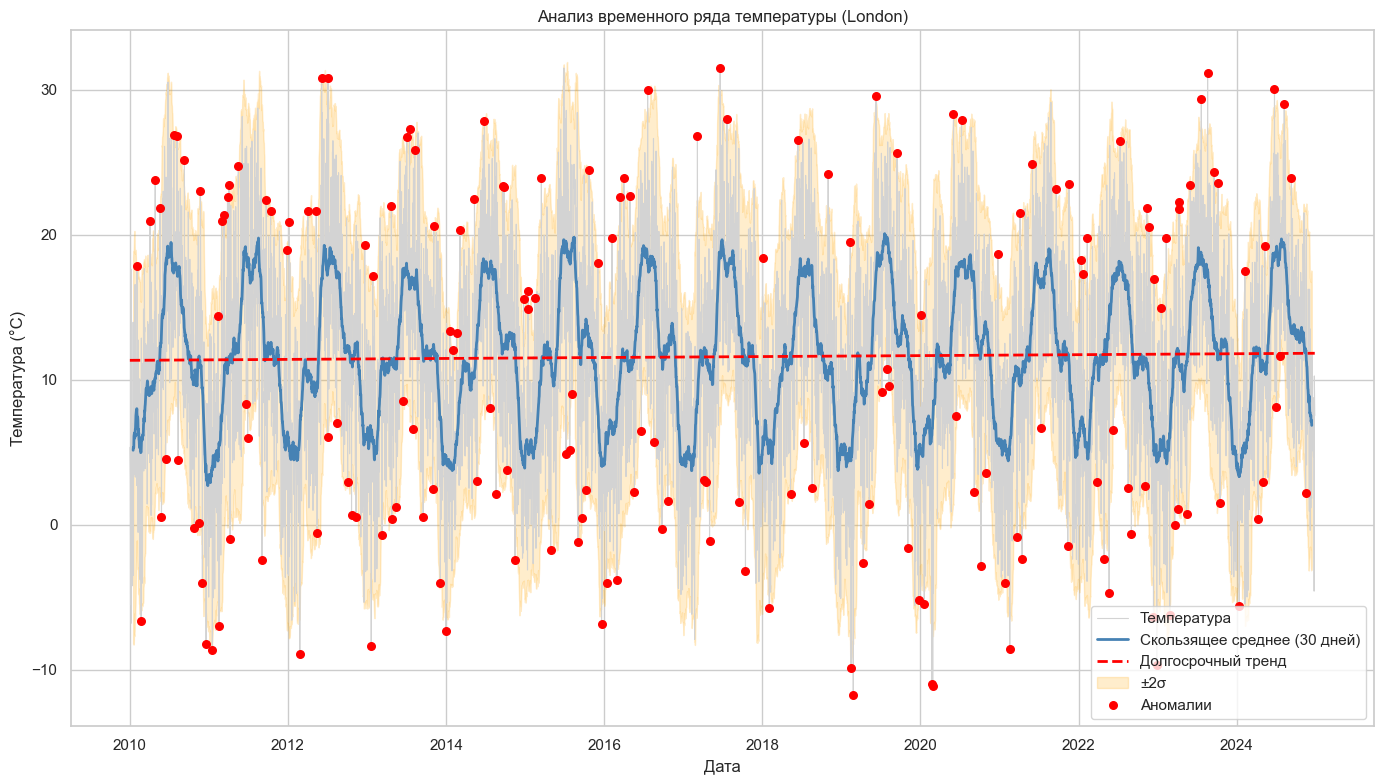

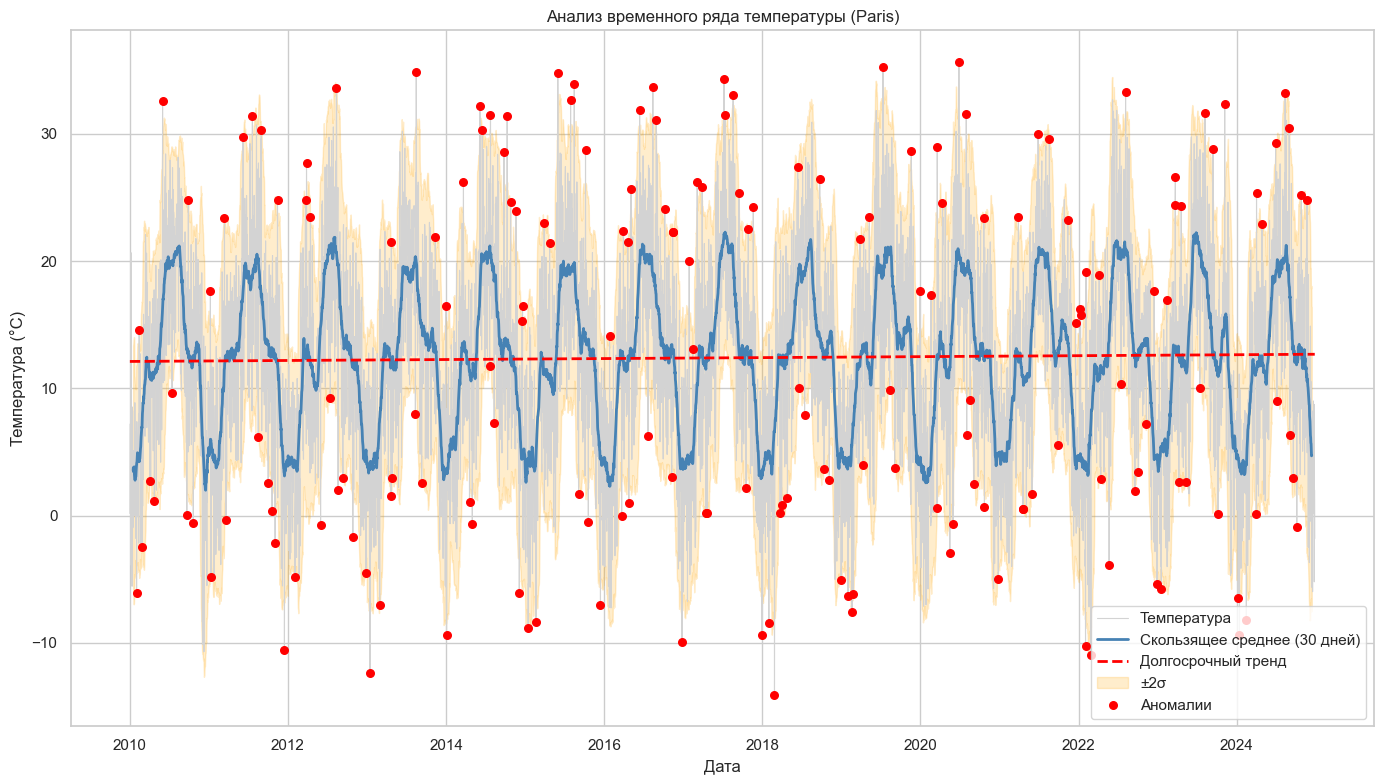

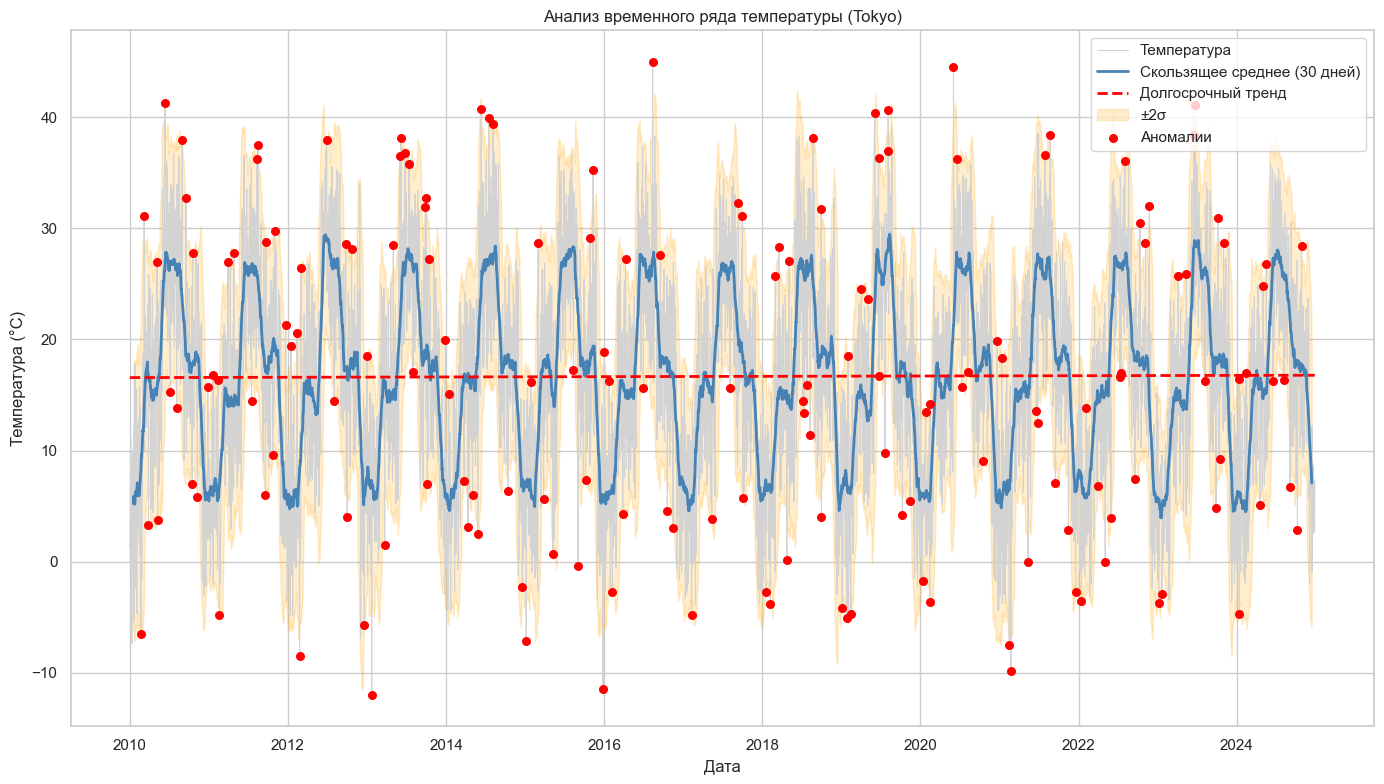

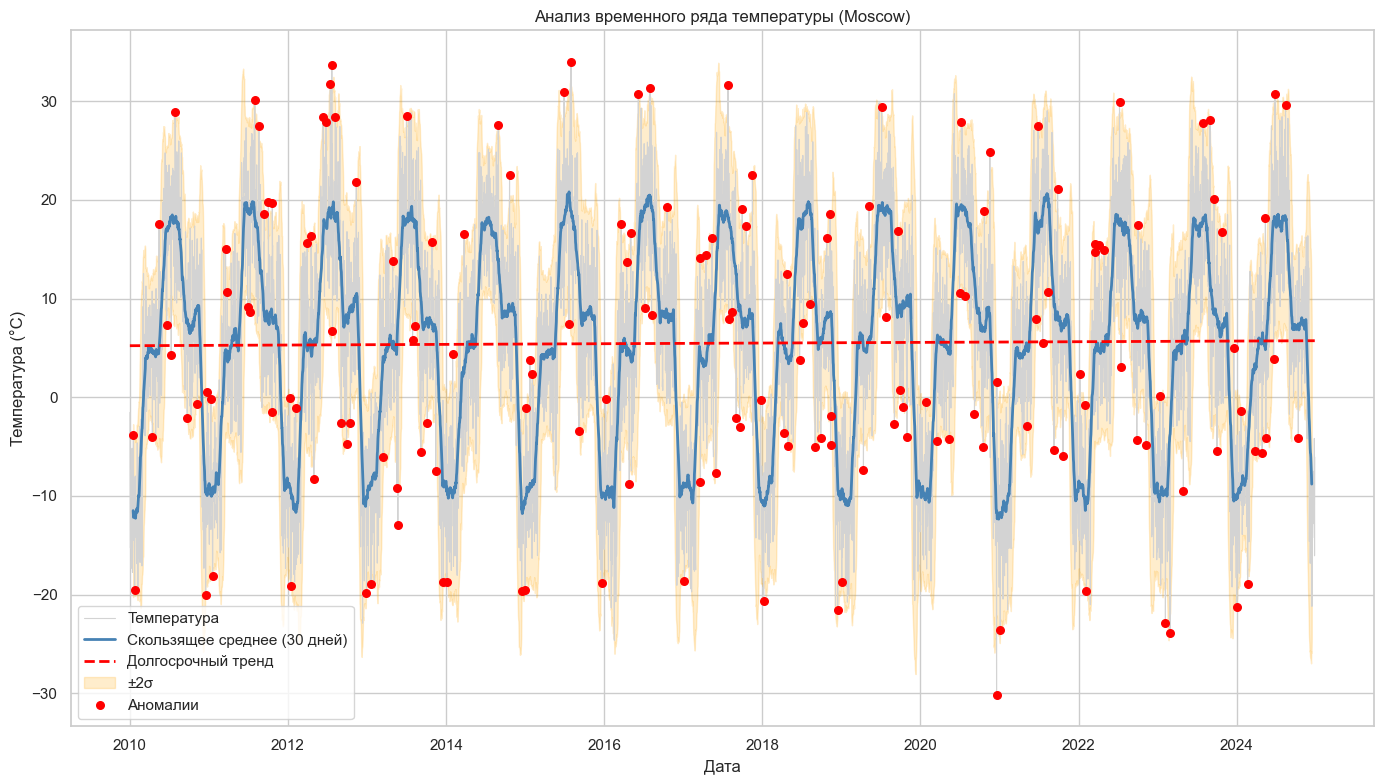

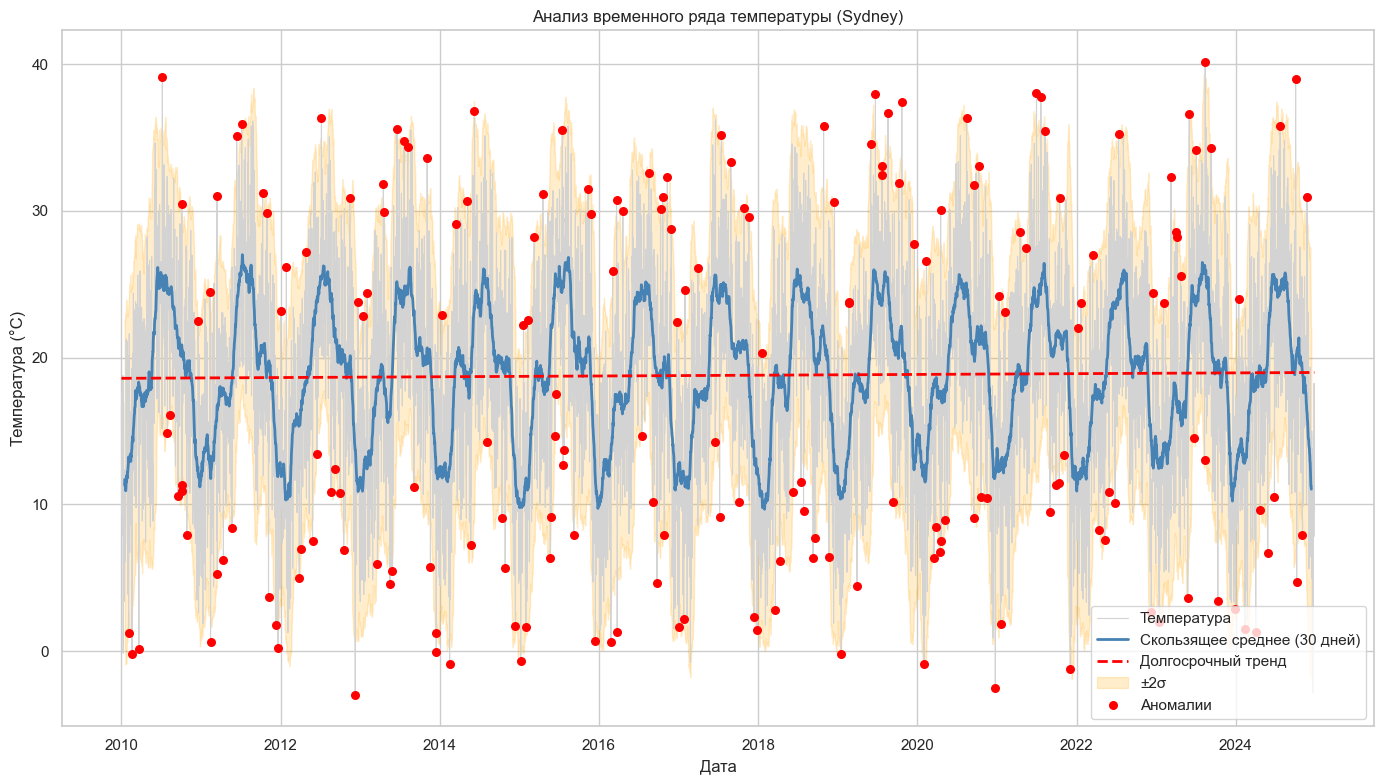

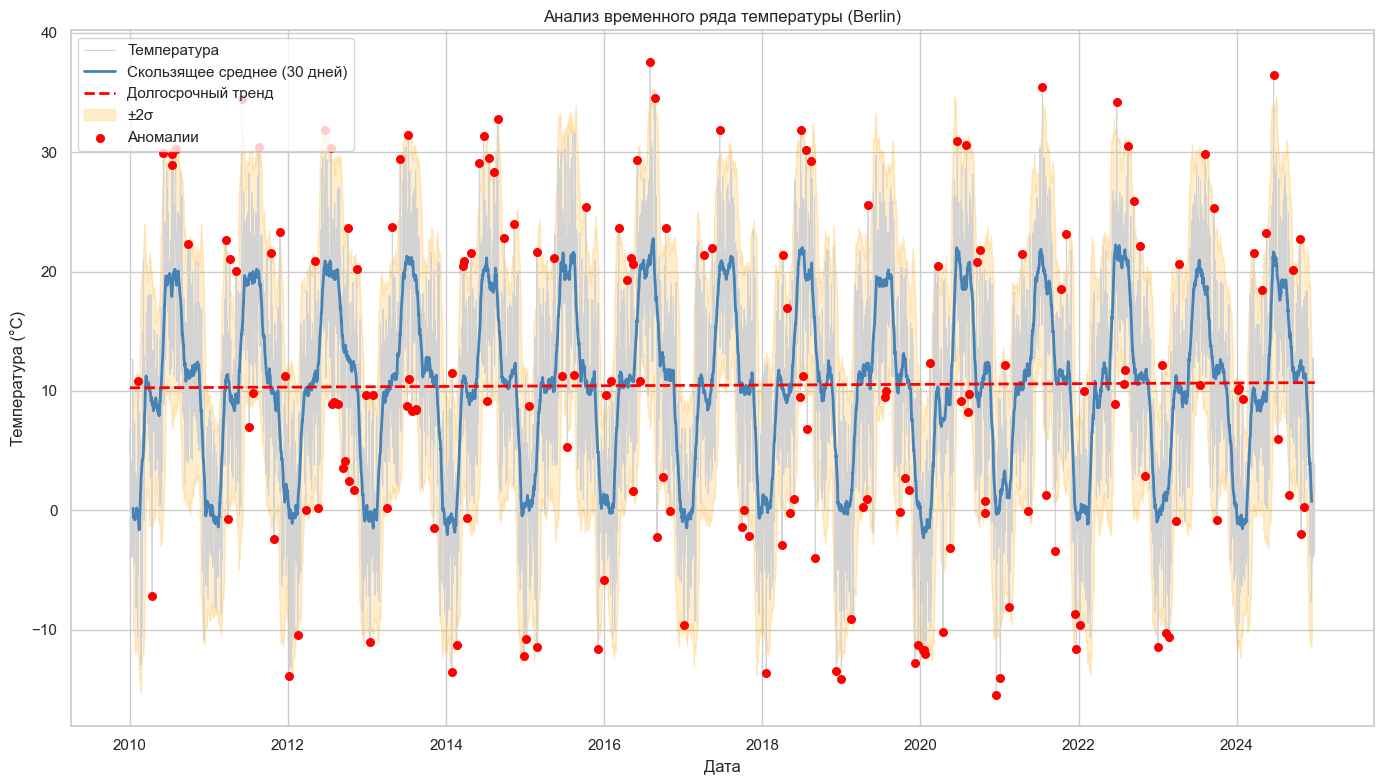

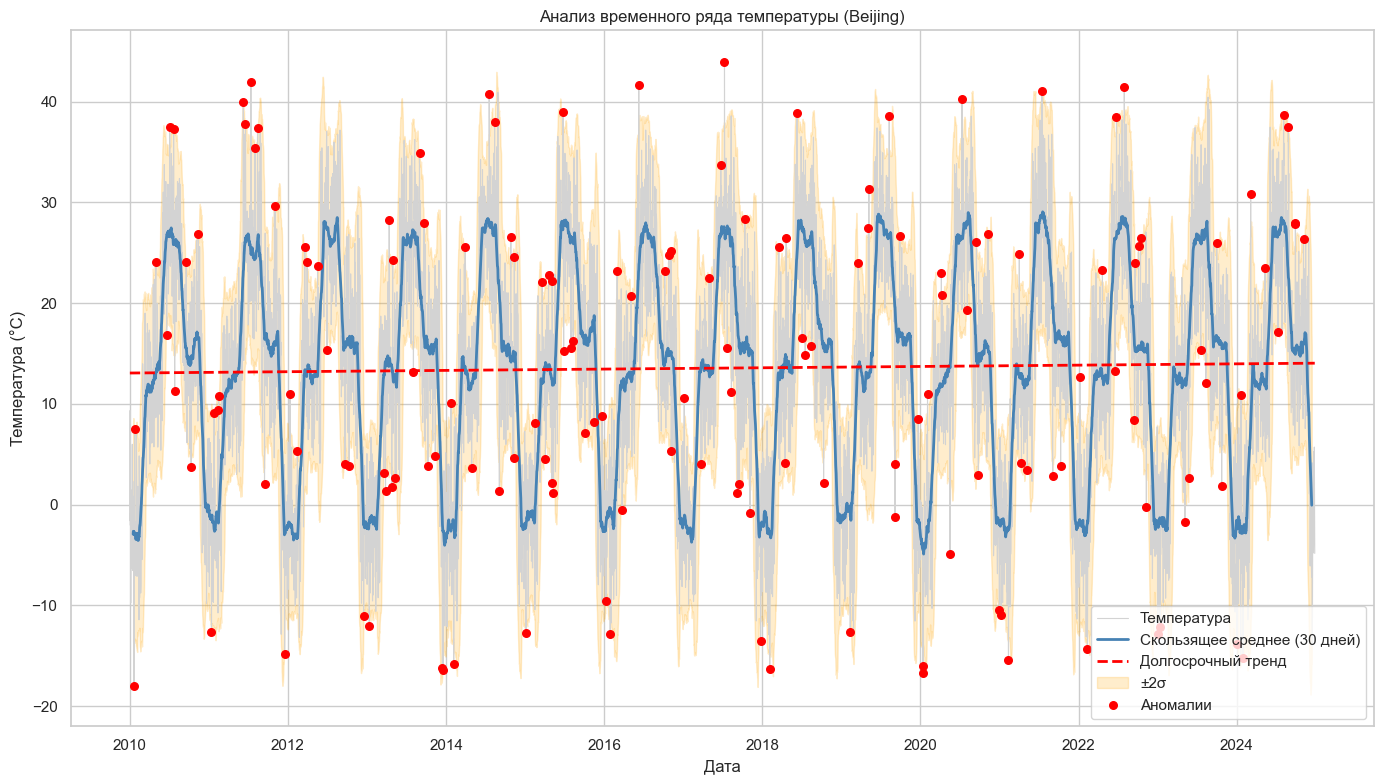

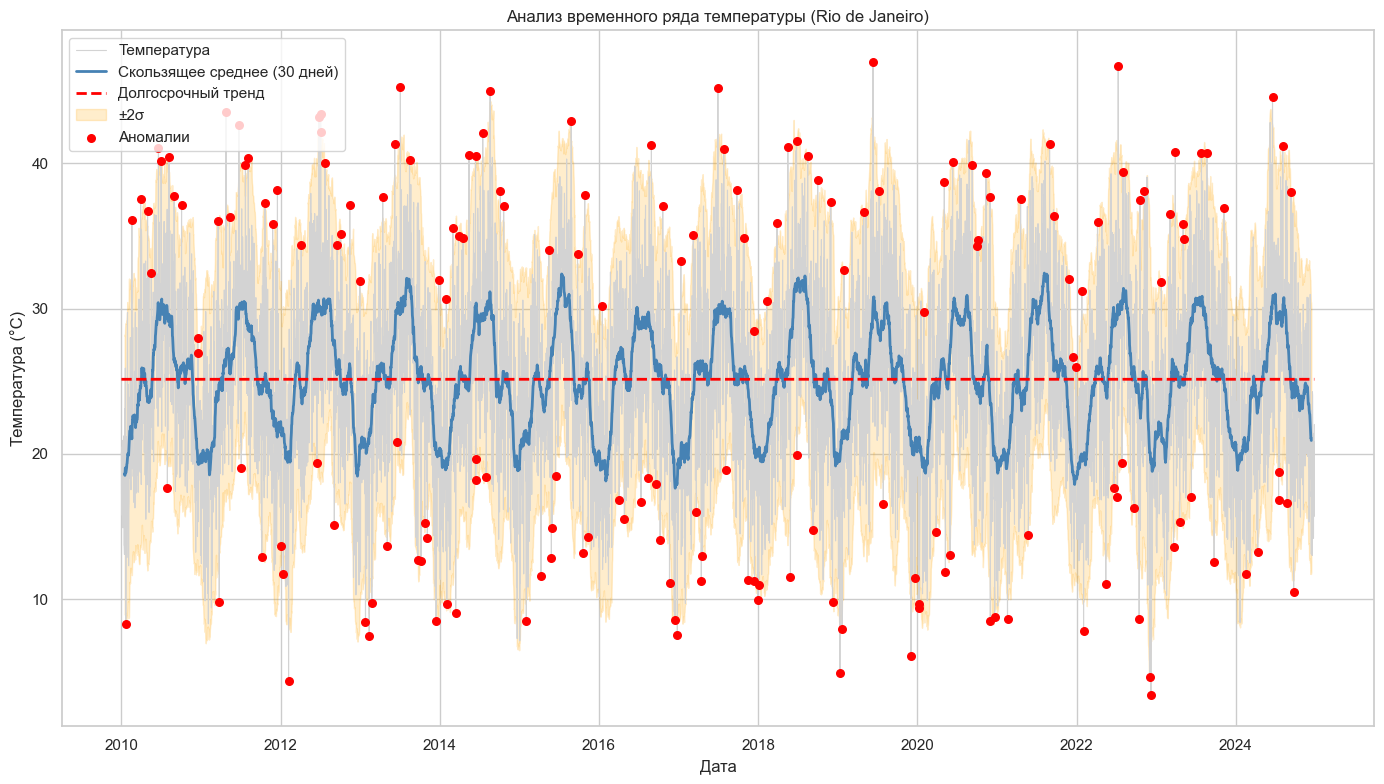

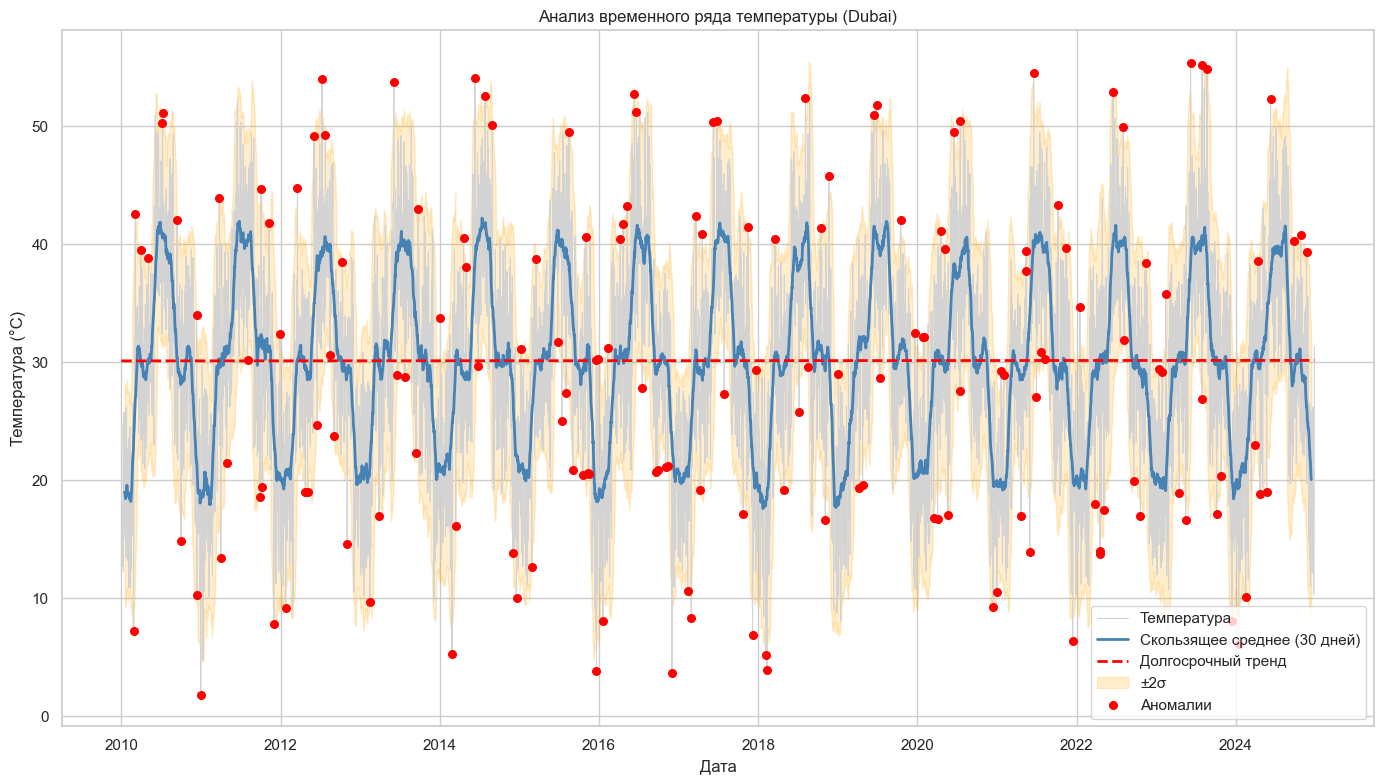

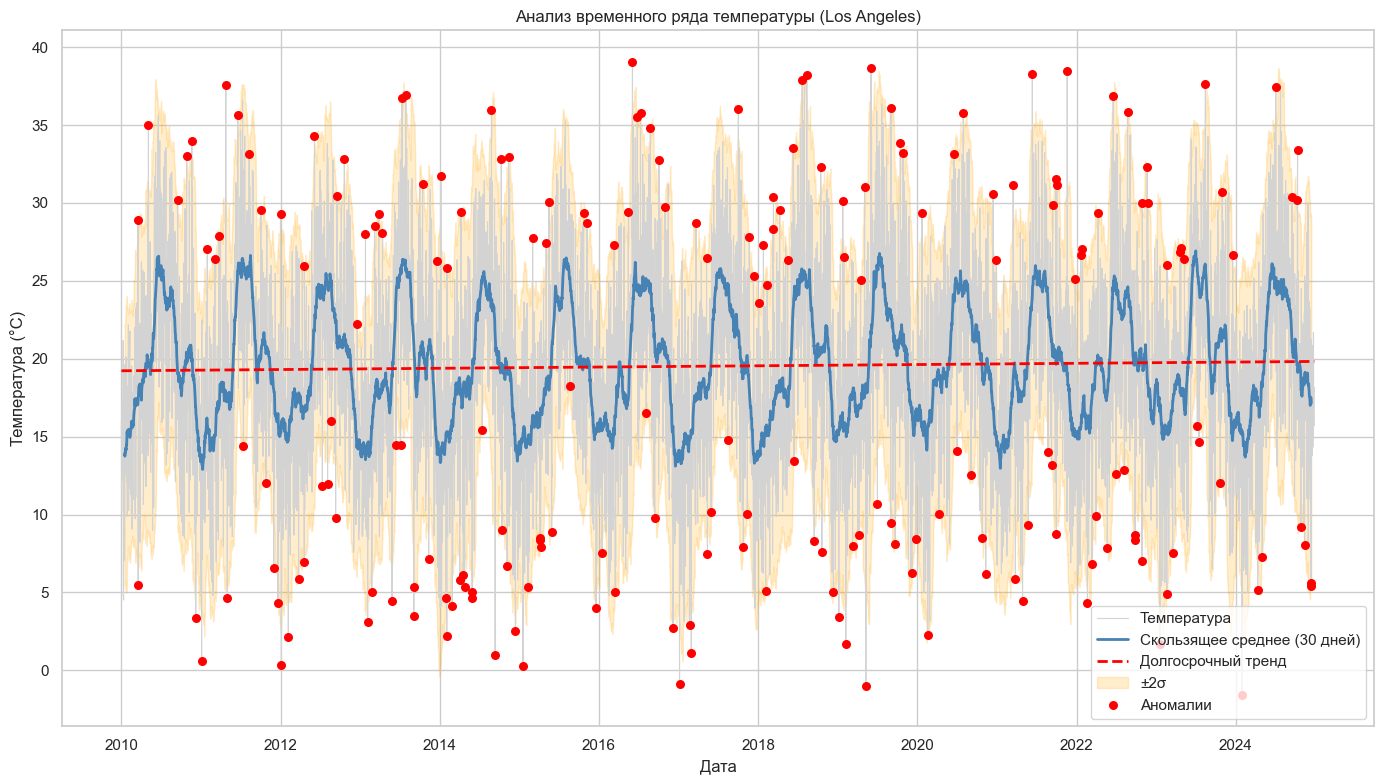

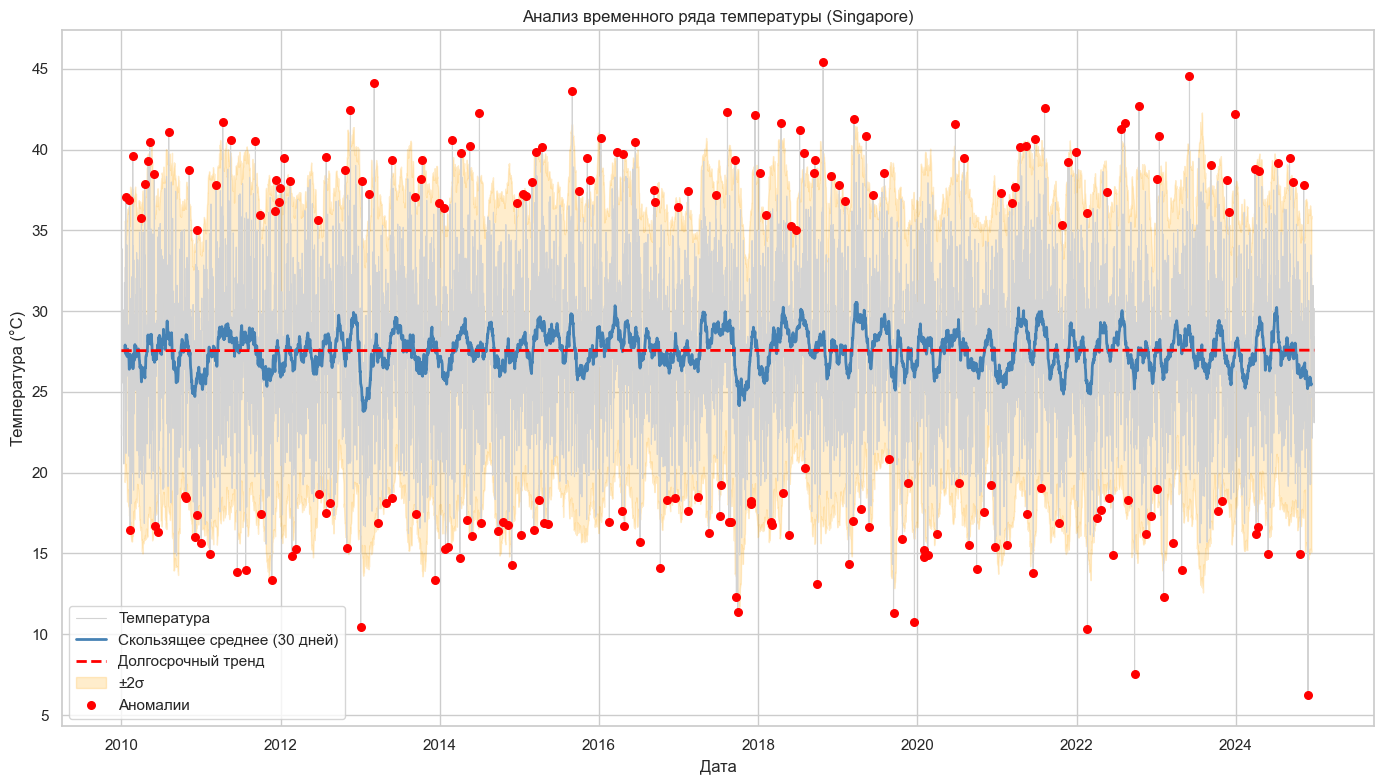

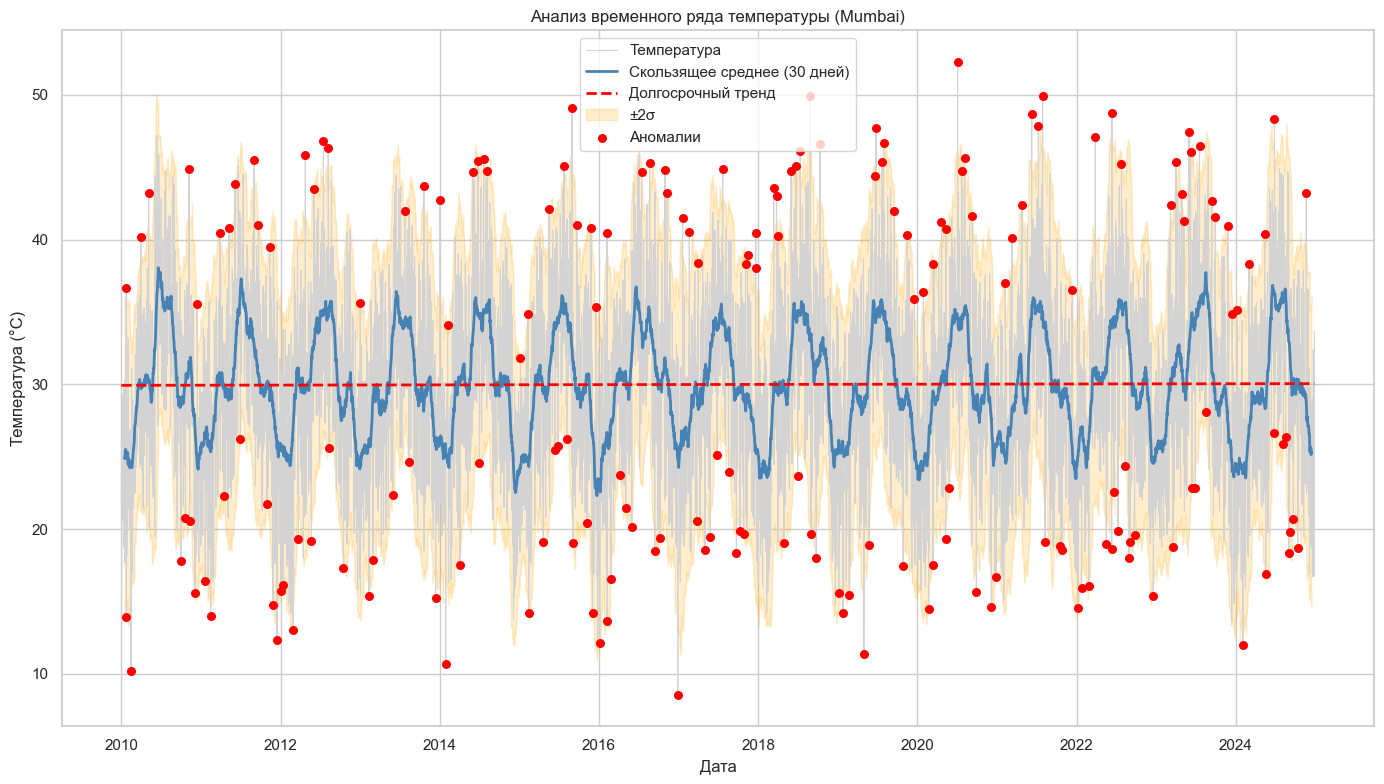

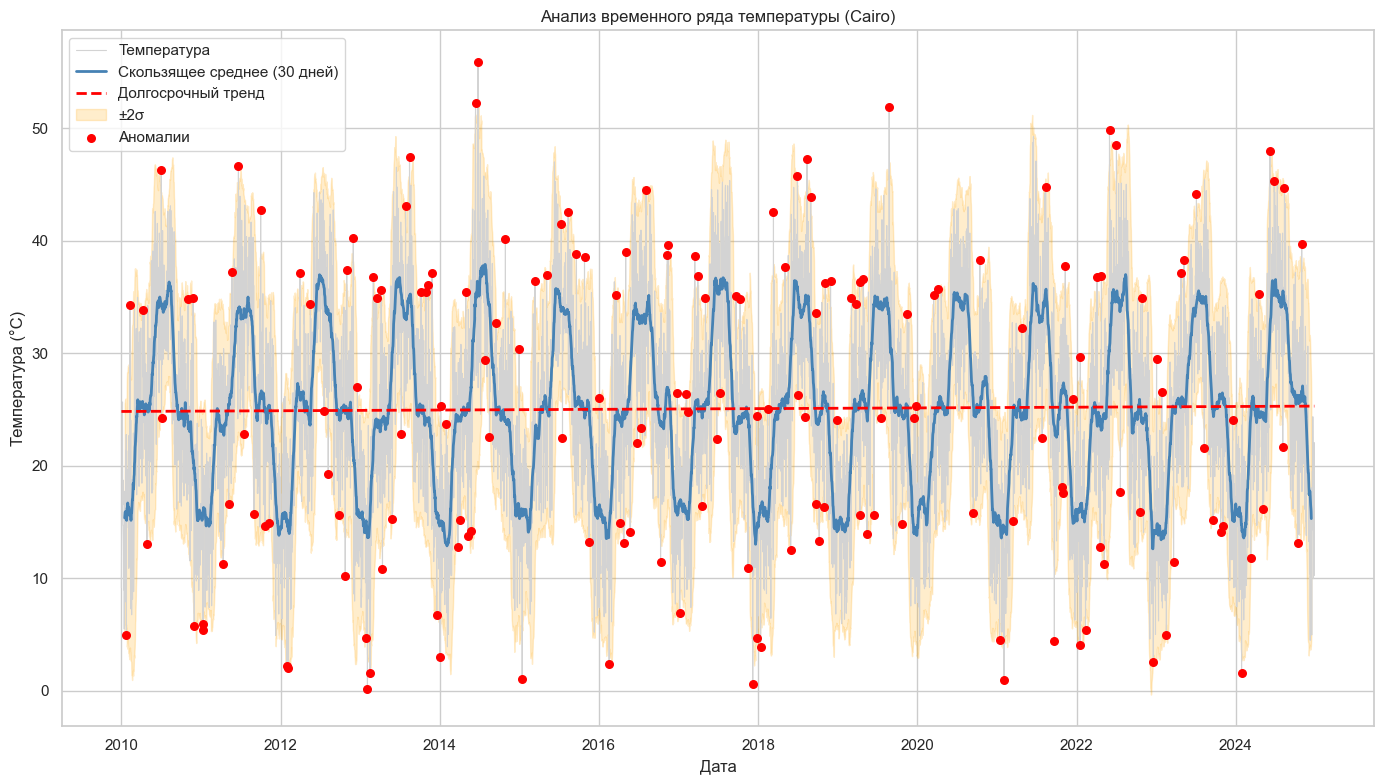

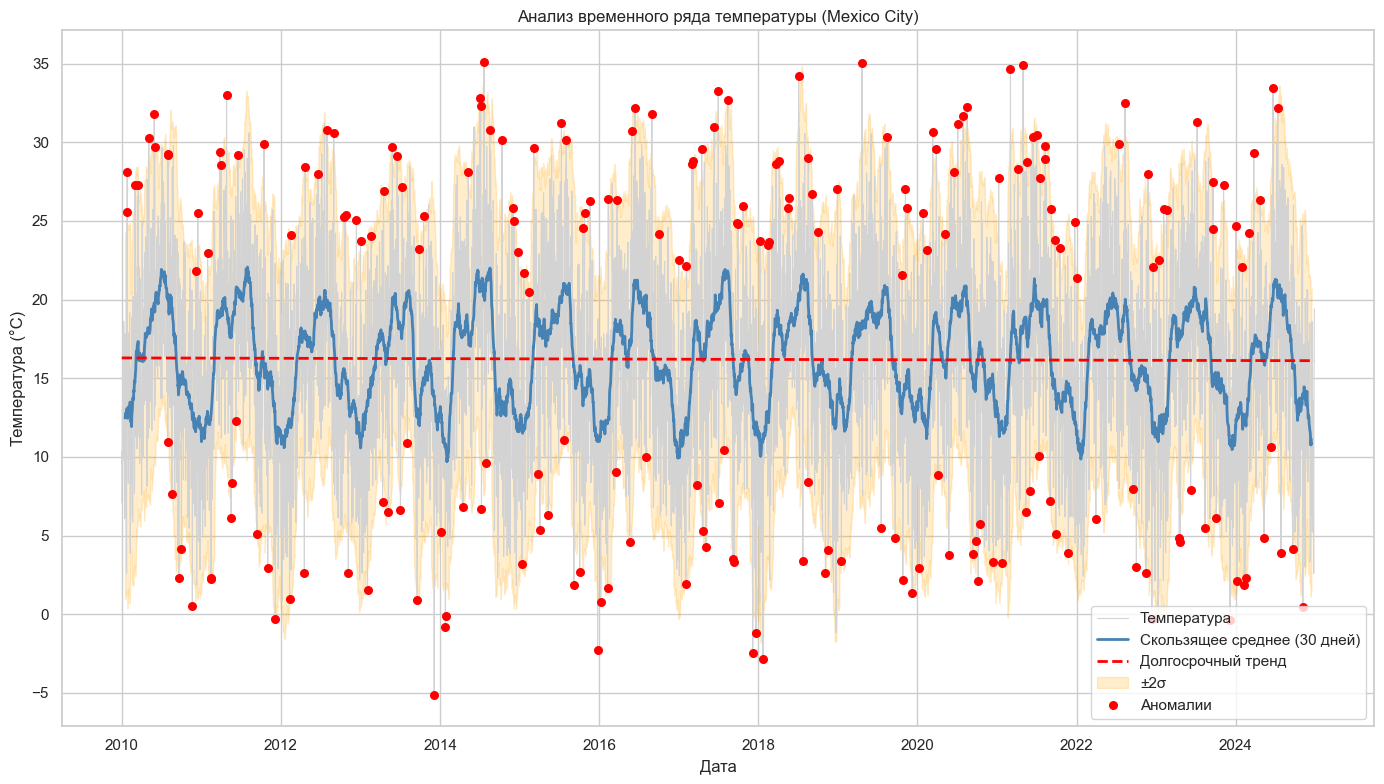

In [7]:
for city in cities:
    analysis_time_series(data, city)

In [8]:
def get_current_weather_for_city(city: str, API_KEY: str):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return (city, data)
    else:
        return None

In [9]:
get_current_weather_for_city("Moscow", API_KEY)

('Moscow',
 {'coord': {'lon': 37.6156, 'lat': 55.7522},
  'weather': [{'id': 803,
    'main': 'Clouds',
    'description': 'broken clouds',
    'icon': '04d'}],
  'base': 'stations',
  'main': {'temp': -8.02,
   'feels_like': -11.65,
   'temp_min': -8.76,
   'temp_max': -7.01,
   'pressure': 1016,
   'humidity': 71,
   'sea_level': 1016,
   'grnd_level': 995},
  'visibility': 10000,
  'wind': {'speed': 1.91, 'deg': 210, 'gust': 3.42},
  'clouds': {'all': 77},
  'dt': 1765779626,
  'sys': {'type': 2,
   'id': 2094500,
   'country': 'RU',
   'sunrise': 1765777995,
   'sunset': 1765803372},
  'timezone': 10800,
  'id': 524901,
  'name': 'Moscow',
  'cod': 200})

Далее идет кое-что интересное: проект можно развить и брать реальные данные о температуре и дальше фантазировать

In [1]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 55.45,
	"longitude": 37.37,
	"start_date": "2025-01-01",
	"end_date": "2025-12-14",
	"hourly": "temperature_2m",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m

hourly_dataframe = pd.DataFrame(data = hourly_data)
print("\nHourly data\n", hourly_dataframe)


NameError: name 'requests_cache' is not defined